In [1]:
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from berrylib.constants import Y_I, Y_I2, N_I, N_I2

# Utility Functions

In [2]:
def logit(x):
    return jnp.log(x) - jnp.log(1 - x)


def log_normal_pdf(x, mu=0, sigma=1):
    return -0.5 * ((x - mu) / sigma) ** 2 - 0.5 * jnp.log(2 * jnp.pi) - jnp.log(sigma)


def log_normal_cdf(x):
    return jnp.log(0.5) + jnp.log(1 + jax.lax.erf(x / jnp.sqrt(2)))


def log_skew_normal_pdf(x, xi, omega, a):
    xt = (x - xi) / omega
    return jnp.log(2) - jnp.log(omega) + log_normal_pdf(xt) + log_normal_cdf(a * xt)


In [3]:
def get_log_berry_likelihood(y, n):
    def log_berry_likelihood(vars):
        theta = vars[:4]
        # TODO: can mu be eliminated?
        mu = vars[4]
        sigma_sq = jnp.abs(vars[5])
        ll = 0.0
        ll += dist.Normal(-1.34, 10).log_prob(mu)
        ll += dist.InverseGamma(0.0005, 0.000005).log_prob(sigma_sq)
        ll += dist.Normal(mu, jax.numpy.sqrt(sigma_sq)).log_prob(theta).sum()
        ll += dist.BinomialLogits(theta+logit(0.3), total_count=n).log_prob(y).sum()
        return ll

    return log_berry_likelihood


In [4]:
y = Y_I2[-1]
n = N_I2[-1]
log_berry_likelihood = get_log_berry_likelihood(y, n)
grad = jax.grad(log_berry_likelihood, 0)
hess = jax.jacobian(grad)

# MCMC

In [5]:
import jax
import numpy as np
import numpyro

# numpyro.enable_x64(True)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS


def mcmc_berry_model(y, n):
    mu = numpyro.sample("mu", dist.Normal(-1.34, 10))
    sigma2 = numpyro.sample("sigma2", dist.InverseGamma(0.0005, 0.000005), obs=100)
    with numpyro.plate("j", 4):
        theta = numpyro.sample(
            "theta",
            dist.Normal(mu, jax.numpy.sqrt(sigma2)),
        )
        numpyro.sample(
            "y",
            dist.BinomialLogits(theta + (np.log(0.3) - np.log(1 - 0.3)), total_count=n),
            obs=y,
        )


def do_mcmc(rng_key, y, n):
    nuts_args = dict(step_size=0.02, adapt_step_size=False)
    nuts_kernel = NUTS(mcmc_berry_model, **nuts_args)
    mcmc = MCMC(
        nuts_kernel,
        progress_bar=False,
        num_warmup=10_000,
        num_samples=1_000_000,
        thinning=10,
    )
    mcmc.run(rng_key, y, n)
    return mcmc.get_samples(group_by_chain=True)


s1 = do_mcmc(jax.random.PRNGKey(0), Y_I2[-1], N_I2[-1])


/home/const/.local/share/virtualenvs/research-DsWMXX3y/lib/python3.8/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


-10.9564495
-2.6519206
-0.25494152
-0.10339418


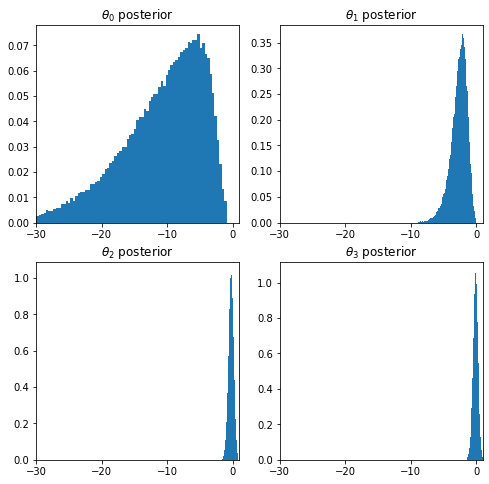

In [17]:
def winsorize(x, q=0.999):
    p = jnp.quantile(x, np.array([1 - q, q]))
    return jnp.clip(x, p[0], p[1])


fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, ax in enumerate(axes.reshape(-1)):
    t = s1["theta"][:, :, i]
    t = winsorize(t)
    print(np.mean(t))
    ax.hist(t, bins=100,  density=True)
    ax.set_title(f"$\\theta_{i}$ posterior")
    ax.set_xlim(-30, 1)
None

# MAP/Mode Estimation

In [7]:
N_ARMS = 4


def pack_vars(theta, mu, sigma):
    return jnp.concatenate([theta, mu, sigma])


def unpack_vars(vars):
    return vars[:N_ARMS], vars[N_ARMS], vars[N_ARMS + 1]


# @jax.jit
def optimize(theta, sigma2, mask):
    """Find the mode/MAP of the posterior distribution of theta given y, n, sigma2.
    
    Mask is an array of indices of theta to be optimized.
    """
    log_berry_likelihood = get_log_berry_likelihood(Y_I2[-1], N_I2[-1])
    grad = jax.grad(log_berry_likelihood, 0)
    hess = jax.jacobian(grad)
    mu = jnp.zeros(1)
    sigma2 = jnp.array(sigma2)[jnp.newaxis]
    vars = pack_vars(theta, mu, sigma2)

    @jax.jit
    def iter(vars):
        """Do a newton iteration."""
        g = grad(vars)
        h = hess(vars)
        g = g[mask]
        h = h[mask][:, mask]
        update = jnp.linalg.solve(h, g)
        vars = vars.at[mask].add(-update)
        return vars
        # assert not jnp.isnan(vars).any()
        # print(jnp.linalg.norm(pvars - vars))

    for _ in range(50):
        vars = iter(vars)
    return vars


def optimize_all():
    sigmas = jnp.power(10, jnp.linspace(-8, 3, 10))
    thetas = jnp.linspace(-10, 10, 10)
    mask = jnp.s_[1:5]
    varss = []
    for sigma2 in sigmas:
        for theta in thetas:
            theta = jnp.zeros(4).at[0].set(theta)
            vars = optimize(theta, sigma2, mask)
            varss.append(vars)
    varss = jnp.stack(varss)
    return varss


# Gaussian Approximation

In [8]:
import scipy.stats

sigma2 = 100
n_arms = 4


def gauss_approx(sigma2, arm_i=0):
    """A gaussian approximation by computing the inverse negative hessian at the mode."""
    theta = jnp.zeros(4)
    mask = jnp.arange(5)
    vars = optimize(theta, sigma2, mask)
    theta, mu, sigma2 = unpack_vars(vars)
    print(vars)
    h = np.linalg.inv(-hess(vars))
    print(h)
    mu = theta[arm_i]
    sigma2 = h[arm_i, arm_i]
    print(mu, sigma2)

    x = jnp.linspace(-40, 10, 100)
    y = scipy.stats.norm(mu, np.sqrt(sigma2)).pdf(x)
    return x, y


x, y = gauss_approx(sigma2)


[-5.4635363e+00 -2.0944355e+00 -2.1600023e-01 -7.1466066e-02
 -1.8370875e+00  1.0000000e+02]
[[ 2.2403597e+01  4.6226807e-02  7.4408553e-03  7.0213242e-03
   4.5207934e+00  2.8100060e+01]
 [ 4.6226807e-02  1.0414199e+00  3.2843807e-04  3.0764594e-04
   2.1777196e-01  1.1609169e-01]
 [ 7.4408553e-03  3.2843807e-04  1.4957021e-01  4.1906060e-05
   3.1394552e-02 -8.2208551e-02]
 [ 7.0213242e-03  3.0764594e-04  4.1906060e-05  1.3999155e-01
   2.9388906e-02 -8.4068984e-02]
 [ 4.5207934e+00  2.1777196e-01  3.1394552e-02  2.9388906e-02
   2.0961967e+01  2.1088638e+00]
 [ 2.8100058e+01  1.1609168e-01 -8.2208551e-02 -8.4068984e-02
   2.1088636e+00 -3.5216223e+03]]
-5.4635363 22.403597


# Laplace Approximation

In [18]:
def conditional_mu(mu, cov, i, x):
    """Return the conditional mean a multivariate normal given a particular arm value.
    
    https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions
    """
    cov12 = jnp.delete(cov[i], i)
    cov22 = cov[i, i]
    mu1 = jnp.delete(mu, i)
    mu2 = mu[i]
    mu_cond = mu1 + cov12 / cov22 * (x - mu2)
    return mu_cond


def laplace_approx(sigma2, arm_i=0):
    """Implement the laplace approximation from Page 329 of:
    Rue, H., Martino, S., & Chopin, N. (2009). Approximate Bayesian inference for latent Gaussian models by using integrated nested Laplace approximations. Journal of the royal statistical society: Series b (statistical methodology), 71(2), 319-392.
    """
    n_points = 51
    # Compute the mode of P(x, | sigma2, y)
    theta = jnp.zeros(4)
    mask = jnp.arange(5)
    vars = optimize(theta, sigma2, mask)

    # Compute the gaussian approximation at the mode
    theta, mu, sigma2 = unpack_vars(vars)

    def gaussian_approx(vars):
        h = jnp.linalg.inv(-hess(vars))
        theta_mu = vars[arm_i]
        theta_sigma2 = h[arm_i, arm_i]
        theta_sigma = jnp.sqrt(theta_sigma2)
        return theta_mu, theta_sigma, h

    theta_mu, theta_sigma, h = gaussian_approx(vars)
    cov = h[:n_arms, :n_arms]
    # xs, wts = np.polynomial.hermite.hermgauss(n_points)
    # xs = xs * theta_sigma * jnp.sqrt(2) + theta_mu
    xs = jnp.linspace(-30, 10, 300)

    # Store the gaussian approximation
    ys1 = jnp.exp(log_normal_pdf(xs, theta_mu, theta_sigma))

    not_arm_i = jnp.delete(jnp.arange(n_arms), arm_i)

    # For a given x_i, compute the laplace approximation at the conditional mode
    def laplace_given_x(x):
        nonlocal theta
        # Instead of the optimized mode, we use the conditional mean instead
        cond_mu = conditional_mu(theta, cov, arm_i, x)
        theta_cond = jnp.zeros(4).at[arm_i].set(x).at[not_arm_i].set(cond_mu)
        vars = pack_vars(theta_cond, mu[jnp.newaxis], sigma2[jnp.newaxis])

        # theta_cond = jnp.zeros(4).at[arm_i].set(x)
        # mask = jnp.delete(jnp.arange(5), arm_i)
        # vars = optimize(theta_cond, sigma2, mask)

        theta_mu, theta_sigma, _ = gaussian_approx(vars)

        y = log_berry_likelihood(vars) - log_normal_pdf(x, theta_mu, theta_sigma)
        y = jnp.exp(y)
        return y

    ys = jax.vmap(laplace_given_x)(xs)
    # ys = [laplace_given_x(x) for x in xs]
    ys = jnp.array(ys)
    ys = jnp.nan_to_num(ys)
    ys /= jnp.trapz(
        ys, xs
    )  # FIXME: this is definitely not the right way to find the normalization constant

    return xs, ys1, ys


arm_i = 0
x, y, y2 = laplace_approx(100, arm_i)


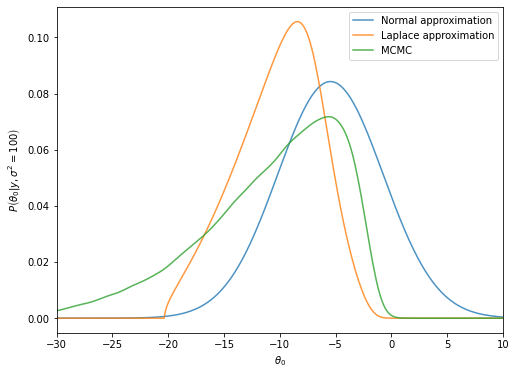

In [19]:
samples = s1["theta"][0, :, arm_i]
kernel = scipy.stats.gaussian_kde(samples)
plt.figure(figsize=(8, 6))
plt.plot(x, y, label="Normal approximation", alpha=0.8)
plt.plot(x, y2, label="Laplace approximation", alpha=0.8)
plt.plot(x, kernel.evaluate(x), label="MCMC", alpha=0.8)
plt.ylabel(r"$P\left(\theta_0 | y, \sigma^2=100 \right)$")
plt.xlabel(r"$\theta_0$")
plt.legend()
plt.xlim(-30, 10)
None


# Skew normal (simplified Laplace approximation)

This is WIP and doesn't work at all yet.

### Algebra for the skew normal parameters:

In [20]:
def translate(s):
    replaces = [
        ("sqrt", "jnp.sqrt"),
        ("^", "**"),
        ("π", "jnp.pi"),
    ]
    for a, b in replaces:
        s = s.replace(a, b)
    return s

equations = [
    "c = (sqrt(π)*g3^(1/3))/(2^(1/6)*(4 - π)^(1/3))",
    "w = (sqrt(π)*sqrt(π*c^2 + 2*(π - 4)*c + π) + π*(c - 1))/(2*(π - 2)*c)",
    "a = w * c",
    "d = sqrt((w*c)^2 * (1 + (w*c)**2))"
]

for e in equations:
    print(translate(e))

# g1 == ξ + ω * δ * jnp.sqrt(2 / jnp.pi)
# 1.0 == ω**2 * (1 - 2 * δ**2 / jnp.pi)
# δ == a / jnp.sqrt(1 + a**2)
# g3 = (4 - jnp.pi) * jnp.sqrt(2) / jnp.pi ** (3 / 2) * (a / ω) ** 3
# "a/ω = c"
# "c = (sqrt(π) g3^(1/3))/(2^(1/6) (4 - π)^(1/3))"
# "δ^2 = (wc)^2 / (1 + (wc)**2)"
# "1.0 = ω**2 * (1 - 2 * δ**2 / pi)"
# "w = sqrt(-0.33333/c^2 + 4.7981/(-339.29*c^8 - 129.10*c^6 + sqrt((-339.29*c^8 - 129.10*c^6)^2 - 47719*c^12))^(1/3) + (0.13228*(-339.29*c^8 - 129.10*c^6 + sqrt((-339.29*c^8 - 129.10*c^6)^2 - 47719*c^12))^(1/3))/c^4)"
# "a = w * c"
# "d = sqrt((wc)^2 / (1 + (wc)**2))"
    


c = (jnp.sqrt(jnp.pi)*g3**(1/3))/(2**(1/6)*(4 - jnp.pi)**(1/3))
w = (jnp.sqrt(jnp.pi)*jnp.sqrt(jnp.pi*c**2 + 2*(jnp.pi - 4)*c + jnp.pi) + jnp.pi*(c - 1))/(2*(jnp.pi - 2)*c)
a = w * c
d = jnp.sqrt((w*c)**2 * (1 + (w*c)**2))


In [21]:
n_arms = 4


def SQR(x):
    return x * x


def GMRFLib_2order_poleq(a, b, c):
    # /*
    #  * solve the equation a*x^2 + b*x + c,
    #  *
    #  * return the two solutions in sol1 and sol2. return GMRFLib_EMISC if there is complex solutions.
    #  */

    tmp = SQR(b) - 4.0 * a * c

    assert tmp > 0.0

    if a == 0:
        sol1 = -c / b
        sol2 = -c / b
    else:
        sol1 = (-b + jnp.sqrt(tmp)) / (2.0 * a)
        sol2 = (-b - jnp.sqrt(tmp)) / (2.0 * a)
    return sol1


def get_skew_normal_params(g1, g3):
    c = 4.58686951235508 * g3
    c = jnp.cbrt(c)
    assert not jnp.isnan(c).any()
    c2 = c * c
    w = (
        jnp.sqrt(jnp.pi) * jnp.sqrt(jnp.pi * c2**2 + 2 * (jnp.pi - 4) * c2 + jnp.pi)
        + jnp.pi * (c2 - 1)
    ) / (2 * (jnp.pi - 2) * c2)
    w = jnp.sqrt(w)
    assert not jnp.isnan(w).any()
    a = w * c
    d = a / jnp.sqrt(1 + a * a)
    assert not jnp.isnan(d).any()
    e = g1 - (w * d * jnp.sqrt(2 / jnp.pi))
    return e, w, a


def get_skew_normal_params2(deriv_log_dens_cond, third_order_derivative):
    a_sigma = jnp.cbrt(third_order_derivative / 0.2180136141449902)
    cc = 1.0 / a_sigma
    sol1 = GMRFLib_2order_poleq(SQR(cc) * (1.0 - 2.0 / jnp.pi), SQR(cc) - 1.0, -1.0)
    alpha = jnp.sqrt(sol1) * (1.0 if third_order_derivative > 0.0 else -1.0)
    aa = alpha
    tmp = 1.0 / (1.0 - (2.0 / jnp.pi) * SQR(aa) / (1.0 + SQR(aa)))
    if tmp > 0.0:
        omega = jnp.sqrt(tmp)
        xi = -deriv_log_dens_cond - omega * jnp.sqrt(2.0 / jnp.pi) * aa / jnp.sqrt(
            1.0 + SQR(aa)
        )
    return alpha, omega, xi


def simple_laplace_approx(sigma2):
    theta = jnp.zeros(4)
    mask = jnp.s_[0:5]
    vars = optimize(theta, sigma2, mask)

    theta, mu, sigma2 = unpack_vars(vars)
    h = np.linalg.inv(hess(vars))
    theta_mu = theta[0]
    theta_sigma2 = h[0, 0]
    theta_sigma = np.sqrt(theta_sigma2)
    # print("theta", theta_mu, theta_sigma2)

    d = grad(vars)
    d3 = jax.jacobian(hess)(vars)

    # deriv_log_dens_cond = 0.0;
    # inv_stdev = 1.0 / x_sd;

    # for (j = 0; j < ai_store->nidx; j+=1):
    #     i = ai_store->correction_idx[j];
    #     corr = covariances[i] * inv_stdev / ai_store->stdev[i];
    #     corr_term = 1.0 - SQR(corr);
    #     deriv_log_dens_cond += ai_store->correction_term[i] * corr_term * derivative[i];
    # deriv_log_dens_cond *= x_sd / 2.0;

    g3 = d3[0][0][0]
    third_order_derivative = 0.0
    # for jjj in range(1, 4):
    #     third_order_derivative += d3[jjj, jjj, jjj] * (d[jjj])**3
    # third_order_derivative *= theta_sigma**3
    g1 = d[0]
    # g3 = third_order_derivative
    # return g1, g3
    print("g", g1, g3)

    # e, w, a = get_skew_normal_params(g1, g3)
    a, w, e = get_skew_normal_params2(g1, g3)
    print(e, w, a)
    d = a / jnp.sqrt(1 + a * a)
    print("mean", e + w * d * jnp.sqrt(2 / jnp.pi))
    print("var", w * w * (1 - 2 * d * d / jnp.pi))
    print(
        "skew",
        (4 - jnp.pi)
        / 2
        * (d * jnp.sqrt(2 / jnp.pi)) ** 3
        / (1 - 2 * d**2 / jnp.pi) ** (3 / 2),
    )

    x = jnp.linspace(-40, 10, 1000)
    y = scipy.stats.norm(theta_mu, np.sqrt(theta_sigma2)).pdf(x)
    xt = (x - theta_mu) / theta_sigma
    # y2 = skew_normal_pdf(x, e, w, a)
    y2 = scipy.stats.skewnorm(a, e, w).pdf(xt)
    # y2 /= theta_sigma
    return x, y, y2


## Skew normal fit using maximum likelihood

In [22]:
import scipy.special

def skew_fit():
    samples = s1["theta"][0, :, 0]
    samples = np.array(samples)
    samples = (samples - np.mean(samples)) / np.std(samples)
    np.random.shuffle(samples)
    x = samples[:10000]
    def loss_fn(x0):
        e, w, a = x0[0], x0[1]**2, x0[2]
        ret = log_skew_normal_pdf(x, e, w, a).sum()
        return -ret
    
    lr = 1e-2
    num_steps = 10000
    params = np.array([0, 1.0, 0.0])
    opt_init, opt_update, get_params = jax.example_libraries.optimizers.adam(lr)
    opt_state = opt_init(params)

    @jax.jit
    def step(step, opt_state):
        value, grads = jax.value_and_grad(loss_fn)(get_params(opt_state))
        opt_state = opt_update(step, grads, opt_state)
        return value, opt_state
    
    for i in range(num_steps):
        value, opt_state = step(i, opt_state)
        if i % 1000 == 0:
            print(i, value)
        assert not jnp.isnan(value).any()


    return get_params(opt_state)
opt = skew_fit()

0 14239.719
1000 12998.391
2000 12926.723
3000 12913.816
4000 12911.091
5000 12910.703
6000 12910.682
7000 12910.681
8000 12910.683
9000 12910.682


## Equations from Rue 2009

2) gaussian approx at x=mu(theta)

p_thetaIy = log_berry_likelihood(vars) - p_x_I_theta_y 

* Note the last term depends on a fixed theta too

$ 2) p(theta|y) = \text{logberrylikelihood}(vars) - .5 * log(-H(f(x_0)))   $

3) p_xiIy = sum(p_xiItheta_y + p_thetaIy for theta in thetas)

* times dTheta

* p_xiItheta_y is skew normal approximation at MAP

$ P(t|y) = P(x, \theta, y) / \text{gaussian}(P(x | t, y)) $

$ P(x_i|t,y) = P(x, \theta, y) / \text{gaussian}(P(x_{-i}|\theta,y)) $

$ P(x_i | y) = \sum(P(x_i|\theta,y) P(\theta|y) \Delta \theta) $

$ P(x_i | y) = \sum(P(x_i|\theta,y) P(\theta|y) \Delta \theta) $

$ \pi_{LA}(x_i | \theta, y) \propto N \left( x_i; \mu_i(\theta), \sigma_i^2(\theta ) \right) \exp \text{cubicspline}(x_i)$

$ \text{spline}(x_i) = \pi_{LA} (x_i | \theta, y) - \pi_G(x_i| \theta, y) $

$ \text{spline}(x_i) = \pi (x, \theta, y) - \pi_GG(x_i| \theta, y) - \pi_G(x_i| \theta, y) $